<a href="https://colab.research.google.com/github/lala991204/ML-self-study/blob/master/8_10_Text_Analysis_Pracice_(Mercari_Price_Suggestion_Challenge).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

다음은 일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격을 예측하는 과제이다.

# 데이터 전처리

In [2]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/github/ML-self-study/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [3]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


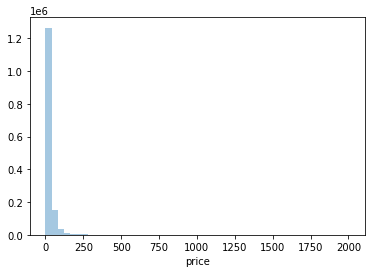

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df, kde=False)       # kde : 커널 밀도 표시

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


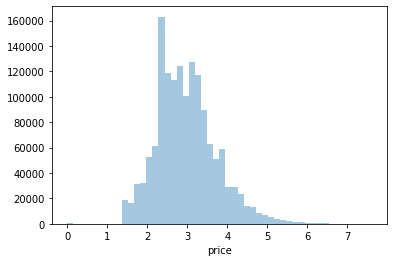

In [5]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

In [6]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [7]:
# 배송비 무료:1. 유료:0
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())

# 판매자가 제공하는 제품 상태
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [8]:
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

'No description yet'의 경우도 Null과 마찬가지로 의미 있는 속성값으로는 사용될 수 없으므로 적절한 값으로 변경해야 함

In [12]:
def split_cat(category_name):  # Men/Tops/T-shirts 를 Men,Tops,T-shirts로 분할함
    try:
        return category_name.split('/')
    except:
        return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat()를 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
                         zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중/소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형: \n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수: ', mercari_df['cat_jung'].nunique())
print('소분류 갯수: ', mercari_df['cat_so'].nunique())

대분류 유형: 
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 갯수:  114
소분류 갯수:  871


In [13]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별 Null 값 건수 확인(모두 0이 나와야 함)
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

# 피처 인코딩과 피처 벡터화

In [14]:
# unique(): 데이터의 고유값 유형, nunique(): 데이터의 고유값 갯수
print('brand name의 유형 건수: ', mercari_df['brand_name'].nunique())

print('brand name sample 5건: \n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수:  4810
brand name sample 5건: 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


In [15]:
print('name의 종류 갯수: ', mercari_df['name'].nunique())
print('name sample 7건: \n', mercari_df['name'][:7])

name의 종류 갯수:  1225273
name sample 7건: 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


In [17]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 갯수
print('item_description 평균 문자열 갯수: ', mercari_df['item_description'].str.len().mean())
mercari_df['item_description'][:2]

item_description 평균 문자열 갯수:  145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [18]:
mercari_df['item_description'][0]

'No description yet'

In [19]:
# name 속성에 대한 feature vectiorization 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 feature vectiorization 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3),
                              stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape: ', X_name.shape)
print('item_description vectorization shpae: ', X_descp.shape)

name vectorization shape:  (1482535, 105757)
item_description vectorization shpae:  (1482535, 50000)


In [20]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [21]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


In [22]:
from  scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
            X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# 사이파이 sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합. 
# 배열을 옆으로 결합하고 싶을 때 사용: hstack
X_features_sparse= hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제. 
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


0

# 릿지 회귀 모델 구축 및 평가

In [25]:
def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds): 
    
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원상복구 필요. 
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [26]:
import gc 
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()     
    
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], 
                                                      test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
    
    del X , X_train , X_test , y_train 
    gc.collect()
    
    return preds , y_test

In [27]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5023727038010544
Item Description을 포함한 rmsle 값: 0.4712195143433641


# LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

In [28]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

LightGBM rmsle 값: 0.45719580244261243


In [29]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4507259214329315
